# Group 7 - MAPD-B PROJECT: Distributed algorithms
## K-Means: Minibatch using pyspark

<font color='blue'>SELECT LastName, FirstName FROM Students <br>
WHERE MAPD_B_Group=7 <br>
ORDER BY LastName ASC <br></font>

Ausilio Lorenzo <br>
Jafarpour Farshad <br>
Martemucci Walter <br>
Prodan George 


## Introduction
The k-means optimization problem is to find the set C of cluster centers c ∈ R m, with |C| = k, to minimize over a set X of examples x ∈ R m the following objective function:
$$||f(C, x) − x||^2$$
Here, f(C, x) returns the nearest cluster center $c$ ∈ $C$ to $x$ using Euclidean distance.

In our project we harnessed mini-batch optimization for K-means clustering. Mini-batches have smaller stochastic noise than examples in SGD:
$$c ← (1 − \eta)c + \eta x $$
where
<ul>
    <li> $c$ is the cluster center
    <li> $\eta$ is learning rate
    <li> $x$ are the sample' features
</ul>

In addition, we implemented a handy method called data parallelization.
Data parallelism is a popular technique used to speed up training on large mini-batches. Under data parallelism, a mini-batch is split up into smaller sized partitions that are small enough to fit on the memory available on different CPU units of the network.

We use "Spark" as a cluster processing engine that allows data to be processed in parallel. Apache Spark's parallelism will enable developers to run tasks parallelly and independently on hundreds of computers in a cluster. All thanks to Apache Spark's fundamental idea, RDD.


### Initialize spark, imports 

In [3]:
import findspark
findspark.init('/usr/local/spark/')

In [4]:
# check some of the env variables
!env | grep -i spark

VIRTUAL_ENV=/usr/local/environments/spark_env
PYSPARK_PYTHON=/usr/local/environments/spark_env/bin/python3
SPARK_HOME=/usr/local/spark/
PATH=/usr/local/environments/spark_env/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/local/spark/bin


Check the content of the SparkSession `spark` object

In [5]:
import numpy as np
import time 
from matplotlib import pyplot as plt 
import time
import numpy
import os
from tqdm import tqdm
import pandas as pd
import math
import seaborn as sns
import statistics as stat
from math import sqrt
from IPython.display import Image
from IPython.core.display import HTML 
from matplotlib import cycler

For each VM, we set up a python evironment ($spark\_{env}$) that uses numpy and scipy to complete the jobs assigned.

In [6]:
os.environ["PYSPARK_PYTHON"]="/usr/local/environments/spark_env/bin/python3"

In [7]:
# settings for the fancy plots
plt.rcParams["font.size"] = 20
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black', labelsize=20)
plt.rc('ytick', direction='out', color='black', labelsize=20)
font = {
        'size'   : 20}
plt.rc('font', **font)
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rcParams["figure.figsize"] = (12,6)

The KMeans class implements the minibatch KMeans algorithm. We have implemented some methods to compute statistics on time measurements. We can deactivate pyspark parallelization by changing the argument $use\_spark$ to $False$.

In [39]:
class KMeans:
    
    def __init__(self, X, use_spark=True, no_clusters=10, steps=16, batch_size=1000, n_partitions=None, tqdm_on=True):
        self.X = X
        self._use_spark = use_spark
        self._k = no_clusters
        self._t = steps
        self._b = batch_size
        self._n_partitions = n_partitions
        self._tqdm_disable = not tqdm_on
        self._time_stats = {'iter_times': [], 'average_time_per_iter': None, 'std': None, 
                            'iter_times_P': [], 'P': 0}
    
    def reset(self):
        self._time_stats = {'iter_times': [], 'average_time_per_iter': None, 'std': None, 
                            'iter_times_P': [], 'P': 0}
        
    def run(self):
        # 1: Given: k, mini-batch size b, iterations t, data set X
        # 2: Initialize each c ∈ C with an x picked randomly from X
        # 3: v ← 0
        k = self._k
        b = self._b
        t = self._t
        X = self.X
        use_spark = self._use_spark
        N = X.shape[0]
        C = np.array([X[np.random.randint(0, N)].toarray() for _ in range(k)])
        v = np.zeros(len(C))
        Y = np.empty(N, dtype=np.int32)

        for i in tqdm(range(t), disable=self._tqdm_disable):
                tic = time.time()
                # 4: for i = 1 to t do
                # 5: M ← b examples picked randomly from X
                mini_batch_idx = np.random.choice(range(N), size=b, replace=False)

                # 6: for x ∈ M do
                # 7: d[x] ← f (C, x) // Cache the center nearest to x
                # 8: end for
                # 9: for x ∈ M do
                # 10: c ← d[x] // Get cached center for this x
                # 11: v[c] ← v[c] + 1 // Update per-center counts
                # 12: η ← 1/v[c] // Get per-center learning rate
                # 13: c ← (1 − η)c + ηx // Take gradient step
                # 14: end for
                # 15: end for

                if use_spark:
                    mini_batch = X[mini_batch_idx]
                    if self._n_partitions is not None:
                        dist_mini_batch_idx = sc.parallelize(mini_batch_idx, self._n_partitions)
                    else:
                        dist_mini_batch_idx = sc.parallelize(mini_batch_idx)
                    Y[mini_batch_idx] = dist_mini_batch_idx.map(lambda idx: (C[:,] - X[idx].toarray()[0][:]) ** 2).map(lambda d2: np.argmin(sum(d2.T))).collect()
                else:    
                    # serial implementation
                    tic2 = time.time()
                    for idx in mini_batch_idx:
                        X_ = X[idx].toarray()
                        d2 = (C[:,] - X_[:]) ** 2
                        Y[idx] = np.argmin(sum(d2.T))
                    toc2 = time.time()
                    self._time_stats['iter_times_P'].append(toc2-tic2)
                for idx in mini_batch_idx:
                    v[Y[idx]] += 1
                    learning_rate = 1 / v[Y[idx]]
                    C[Y[idx]] = (1 - learning_rate) * C[Y[idx]] + learning_rate * X[idx]
                toc = time.time()
                self._time_stats["iter_times"].append(toc - tic)
                
        self._time_stats["average_time_per_iter"] = np.mean(self._time_stats["iter_times"])
        self._time_stats["std"] = np.std(self._time_stats["iter_times"])
        if not use_spark:
            self._time_stats["P"] = np.mean(self._time_stats["iter_times_P"]) / self._time_stats["average_time_per_iter"]
    
    def get_time_stats(self, verbose=True):
        if verbose:
            print(f'average time per iteration = {round(self._time_stats["average_time_per_iter"], 2)} seconds')
            print(f'STD = {round(self._time_stats["std"], 2)} seconds')
            print(f'P = {round(self._time_stats["P"], 4)}')
        return str(self._time_stats["average_time_per_iter"]) + ',' + str(self._time_stats['std'])
    
    def get_ave_time_per_iter(self):
        return self._time_stats["average_time_per_iter"]
    
    def set_partitions(self, partitions_):
        self._n_partitions = partitions_
    
    def set_minibatch(self, b_):
        self._b = b_
        
    def set_clusters(self, k_):
        self._k = k_

In [43]:
# 
sc.stop()
spark.stop()

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

master_url = "spark://10.67.22.172:7077"

spark = SparkSession.builder \
        .master(master_url)\
        .config("spark.blockManager.port", "10025")\
        .config("spark.driver.blockManager.port", "10026")\
        .config("spark.driver.port", "10027")\
        .config("spark.cores.max", "6")\
        .config("spark.executor.memory", "6800m")\
        .config("spark.driver.host", "10.67.22.172")\
        .appName("KMeansApp")\
        .getOrCreate()

sc = spark.sparkContext
sc


### RCV1 dataset loading

In [11]:
from sklearn.datasets import fetch_rcv1

rcv1 = fetch_rcv1()
X_train = rcv1.data[0:23149]
X_test = rcv1.data[23149:]
y_train = rcv1.target[0:23149].toarray()
y_test = rcv1.target[23149:].toarray()

In [12]:
print('the number of unique targets:', len(np.unique(y_train, axis=0)))

the number of unique targets: 1589


In [ ]:
k = 10
b = 1000
t = 16
ts = int(time.time()) % 1000000
workers = 12
cores_per_worker = 1
n_cores = workers * cores_per_worker
g = open(f'./experiments/kmeans_{ts}_b{b}_k{k}_t{t}_{workers}{cores_per_worker}_5x', 'a+')
kmeans = KMeans(X_train, batch_size=b, steps=8, n_partitions=5*n_cores, tqdm_on=True)
kmeans.run()
g.write(kmeans.get_time_stats())
g.close()

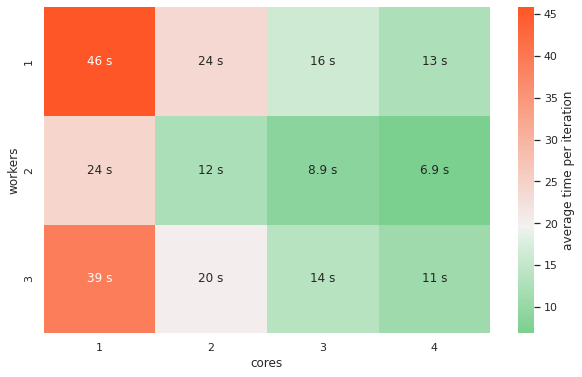

In [49]:
workers = [1]*4 + [2]*4 + [3]*4 
cores = [1,2,3,4]*3
time = [45.7676297724247,
        23.747789606451988,
        16.180573046207428,
        12.569230452179909,
        24.28873172402382,
        12.283212691545486,
        8.8641247600317,
        6.913647651672363,
        38.9780380576849,
        20.07382282614708,
        13.89051952958107,
        10.960398718714714]

sns.set(rc = {'figure.figsize':(10,6)})
data = pd.DataFrame({'workers': workers, 'cores': cores, 'time': time})
data_pivoted = data.pivot("workers", "cores", "time")
cmap = sns.diverging_palette(130, 18, s=100, l=60, n=10, as_cmap=True)
ax = sns.heatmap(data_pivoted, cmap=cmap, center=stat.mean(time), annot=True,cbar_kws={'label': 'average time per iteration'})
for t in ax.texts: t.set_text(t.get_text() + " s")
plt.show()
Image(url= "https://github.com/waltermartemucci/MAPDmod.B/blob/main/12partitions.jpeg?raw=true")

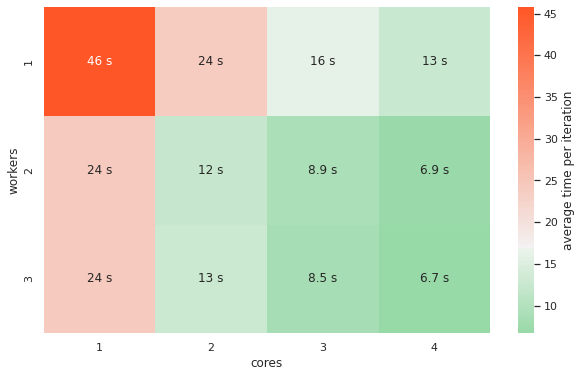

In [50]:
time = [45.7676297724247,
        23.747789606451988,
        16.180573046207428,
        12.569230452179909,
        24.28873172402382,
        12.283212691545486,
        8.8641247600317,
        6.913647651672363,
        24.39110040664673,
        12.699621200561523,
        8.52303896844387,
        6.682660311460495]

sns.set(rc = {'figure.figsize':(10,6)})
data = pd.DataFrame({'workers': workers, 'cores': cores, 'time': time})
data_pivoted = data.pivot("workers", "cores", "time")
cmap = sns.diverging_palette(130, 18, s=100, l=60, n=10, as_cmap=True)
ax = sns.heatmap(data_pivoted, cmap=cmap, center=stat.mean(time), annot=True,cbar_kws={'label': 'average time per iteration'})
for t in ax.texts: t.set_text(t.get_text() + " s")
plt.show()
Image(url= "https://github.com/waltermartemucci/MAPDmod.B/blob/main/24partitions.jpeg?raw=true")

### Performance / memory per executor

In [ ]:
k = 10
b = 10000
t = 4
ts = int(time.time()) % 1000000
workers = 12
cores_per_worker = 1
n_cores = workers * cores_per_worker
g = open(f'./experiments/memory_exp_{ts}_b{b}_k{k}_t{t}_{workers}{cores_per_worker}_5x', 'a+')
kmeans = KMeans(X_train, batch_size=b, n_partitions=5*n_cores, steps=t, tqdm_on=False)
for m_ in tqdm(range(1000,7000,500)):
    sc.stop()
    spark = SparkSession.builder \
        .master(master_url)\
        .config("spark.blockManager.port", "10025")\
        .config("spark.driver.blockManager.port", "10026")\
        .config("spark.driver.port", "10027")\
        .config("spark.cores.max", "12")\
        .config("spark.executor.memory", str(m_) + 'm')\
        .config("spark.driver.host", "10.67.22.172")\
        .appName("KMeansApp")\
        .getOrCreate()
    sc = spark.sparkContext
    kmeans.reset()
    kmeans.run()
    g.write(str(m_) + ',' + str(kmeans.get_time_stats(verbose=False)) + '\n')
g.close()


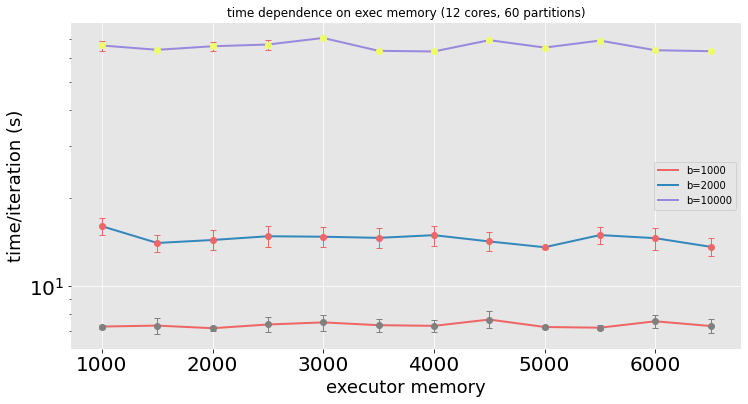

In [30]:
def read_exp_data(f, err=False):
    with open(f'./experiments/{f}', 'r') as f:
        data = f.readlines()

    oX = [float(line.replace('\n', '').split(',')[0]) for line in data]
    oY = [float(line.replace('\n', '').split(',')[1]) for line in data]
    if err:
        err_Y = [float(line.replace('\n', '').split(',')[2]) for line in data]
        return oX, oY, err_Y
    
    return oX, oY

f = 'memory_exp_740826_b1000_k10_t8_121_5x'
f2 = 'memory_exp_741931_b2000_k10_t8_121_5x'
f3 = 'memory_exp_898669_b10000_k10_t4_121_5x'
x, y, err = read_exp_data(f, err=True)
x2, y2, err2 = read_exp_data(f2, err=True)
x3, y3, err3 = read_exp_data(f3, err=True)

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(x, y, label='b=1000')
plt.plot(x2, y2, label='b=2000')
plt.plot(x3, y3, label='b=10000')
plt.errorbar(x, y, yerr=err, fmt="o", color='grey', ecolor='grey', capsize=3, elinewidth=1)
plt.errorbar(x2, y2, yerr=err2, fmt="o", color='#EE6666', ecolor='#EE6666', capsize=3, elinewidth=1)
plt.errorbar(x3, y3, yerr=err3, fmt="o", color='#EEFF66', ecolor='#EE6666', capsize=3, elinewidth=1)
plt.xlabel('executor memory', fontsize=18)
plt.ylabel('time/iteration (s)', fontsize=18)
plt.yscale('log')
plt.legend()
plt.title('time dependence on exec memory (12 cores, 60 partitions)')
plt.show()

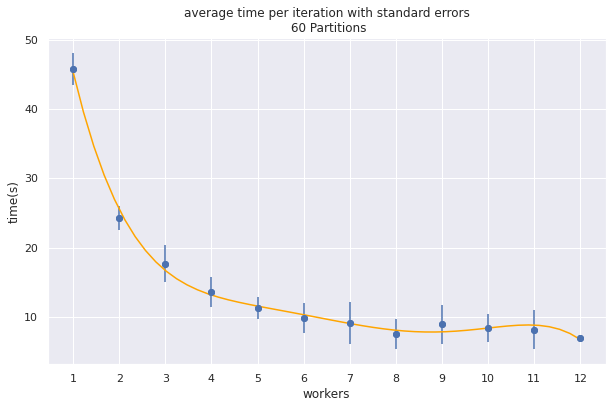

In [51]:
time_12w =  [45.7676297724247,
            24.28873172402382,
            17.7080048173666,
            13.6370609998703,
            11.280178919434547,
            9.852460086345673,
            9.15173614025116,
            7.532218337059021,
            8.965942099690437,
            8.386710539460182,
            8.178176447749138,
            7.002316877245903]
std_12w = [0.668774765587137,
            0.48706860016254955,
            0.755151773474399,
            0.6324654603410612,
            0.47050407459233984,
            0.632185739733132,
            0.887821356722078,
            0.638520238691201,
            0.813740571117948,
            0.5869957102589364,
            0.825578767057707,
            0.11866462091431716]
ste_12w = [i * sqrt(len(std_12w)) for i in std_12w]
add_workers = list(np.arange(1,13))

plt.scatter(add_workers, time_12w)

plt.errorbar(add_workers, time_12w, yerr=ste_12w, fmt="o")
plt.xticks(add_workers)
plt.title("average time per iteration with standard errors\n 60 Partitions")
plt.xlabel("workers")
plt.ylabel("time(s)")
model5 = np.poly1d(np.polyfit(add_workers, time_12w, 5))
polyline = np.linspace(1, 12, 50)
plt.plot(polyline, model5(polyline), color='orange')
plt.show()

### About efficiency

#### Definitions : 
- `Performance` is an attribute that refers to the total elapsed time of an algorithm's execution. Less elapsed time = higher performance <br>
- `Speed up` is a metric that quantifies performance : $\boxed{S(n)=\frac{t_s}{t_p(n)}} $ where $t_s$ : time needed to run on one processor and $t_p(n)$ is the time needed to run on $n$ processors <br>
- `Efficiency` is a metric that builds on top of Speed up up by adding awareness of the underlying hardware. $\boxed{\eta_s=\frac{S(n)}{n}} $. 
    - As a rule of thumb $\eta_s$ should be $\ge$ 0.5  
If $\eta_s = 0.5$ , only half of the processors
were used to gain the speedup and the other half were idle.

We can use these to estimate how much computing power is used to carry out calculations vs how much is used for communication between the parallel processes.<br>

#### Amdahl's law:
Is used to predict the theoretical maximum `Speed up` when using multiple processors. <br>
- stated as : $\boxed{S(n)_{max} = \frac{1}{(1-p)+ \frac{p}{n}}} $ where <br>
    - p : fraction of parallelizable processing
    - 1-p : fraction of serial processing (which can't be parallelized)
    - n : number of processing units <br>
- and $\boxed{\lim_{n \to +\infty} S(n)_{max} = \frac{1}{1-p}} $ which can be used when the number of processing units is very large. <br> <br>
__Even if $n \to +\infty$, the Speed up will be capped by the serial part.__ <br>
__Often considered as pessimistic.__

<img src="https://github.com/waltermartemucci/MAPDmod.B/blob/main/Amdahls_Law.png?raw=true" width="500" height="500" align="center"/>

__The greater the parallel portion, the more processors are needed to attain the theoretical limit.__ <br>
__In our case p was measured to be 0.9936 $\rightarrow$ roughly 99% of exection time is spent doing parallel tasks. The sequential part for us was only the update of the clusters.__

<img src="https://github.com/waltermartemucci/MAPDmod.B/blob/main/amdahls_law_ourP.png?raw=true" width="650" height="650" align="center"/> <br>
__Following Amdahl's Law, the amount of processors needed to reach the maximum Speedup is very large.__ <br> <br>
__We can compare this to what we actually were able to observe using the virtual machines :__

<img src="https://github.com/waltermartemucci/MAPDmod.B/blob/main/amdahls_law_vs_our_with_Ebars.png?raw=true" width="650" height="650" align="center"/>

#### Gustafson's Law 
- Another way to compute the theoretical maximum `Speed up` <br>
- stated as $\boxed{S(n)_{max} = s + p*n} $ where
    - s : serial fraction time
    - p : parallel fraction time
    - n : number of processors
 <img src="https://github.com/waltermartemucci/MAPDmod.B/blob/main/gustafsons_law.png?raw=true" width="550" height="550" align="center"/><br>
 __Addresses shortcomings of Amdahl's Law :  Gustafson's law tells us that attainable speedup is often related to problem size not just the number of processors used. In essence Amdahl’s law assumes that the percentage of serial code is independent of problem size.__

<img src="https://github.com/waltermartemucci/MAPDmod.B/blob/main/gustafsons_law_notcut.png?raw=true" width="550" height="550" align="center"/><br>

#### Efficiency
<img src="https://github.com/waltermartemucci/MAPDmod.B/blob/main/efficiency_updated.png?raw=true" width="650" height="650" align="center"/>

### Partitions experiment 

In [ ]:
k = 10
b = 1000
ts = int(time.time()) % 1000000
workers = 3
cores_per_worker = 4
n_cores = workers * cores_per_worker
t_arr = []
g = open(f'./experiments/partitions_exp_{ts}_b{b}_k{k}_t{1}_{workers}{cores_per_worker}', 'a+')
kmeans = KMeans(X_train, steps=1, tqdm=False)
for partitions_ in tqdm(range(106,144)):
    kmeans.reset()
    kmeans.set_partitions(partitions_)
    kmeans.run()
    t_arr.append(kmeans.get_ave_time_per_iter())
    g.write(str(partitions_) + ',' + str(kmeans.get_ave_time_per_iter()) + '\n')
g.close()

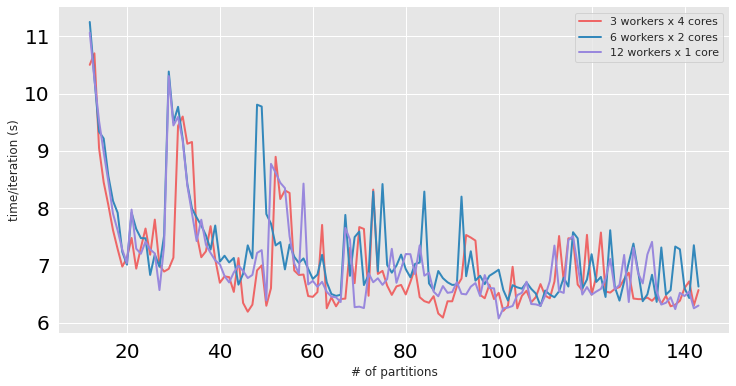

In [76]:
f1 = 'partitions_exp_678382_b1000_k10_t1_34'
f2 = 'partitions_exp_661681_b1000_k10_t1_62'
f3 = 'partitions_exp_647721_b1000_k10_t1_121'

x1, y1 = read_exp_data(f1)
x2, y2 = read_exp_data(f2)
x3, y3 = read_exp_data(f3)

plt.plot(x1, y1, label='3 workers x 4 cores')
plt.plot(x2, y2, label='6 workers x 2 cores')
plt.plot(x3, y3, label='12 workers x 1 core')
plt.xlabel('# of partitions')
plt.ylabel('time/iteration (s)')
plt.legend()
plt.show()

### Minibatch experiment

In [ ]:
k = 10
b = 1000
ts = int(time.time()) % 1000000
workers = 6
cores_per_worker = 1
n_cores = workers * cores_per_worker
t_arr = []
g = open(f'./experiments/minibatch_exp_{ts}_k{k}_t{1}_{workers}{cores_per_worker}', 'a+')
kmeans = KMeans(X_train, use_spark=True, no_clusters=k, 
                steps=1, batch_size=None, n_partitions=60, tqdm_on=False)
for b_ in tqdm([32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]):
    kmeans.reset()
    kmeans.set_minibatch(b_)
    kmeans.run()
    t_arr.append(kmeans.get_ave_time_per_iter())
    g.write(str(b_) + ',' + str(kmeans.get_ave_time_per_iter()) + '\n')
g.close()

### Clusters experiment

In [ ]:
b = 1000
ts = int(time.time()) % 1000000
workers = 6
cores_per_worker = 1
n_cores = workers * cores_per_worker
t_arr = []
g = open(f'./experiments/clusters_exp_{ts}_k{k}_t{1}_serial', 'a+')
kmeans = KMeans(X_train, use_spark=False, no_clusters=4, 
                steps=1, batch_size=b, n_partitions=60, tqdm_on=False)
for k_ in tqdm([4, 8, 16, 32, 64, 128, 256, 512]):
    kmeans.reset()
    kmeans.set_clusters(k_)
    kmeans.run()
    t_arr.append(kmeans.get_ave_time_per_iter())
    g.write(str(k_) + ',' + str(kmeans.get_ave_time_per_iter()) + '\n')
g.close()

### A comparison to serial KMeans 

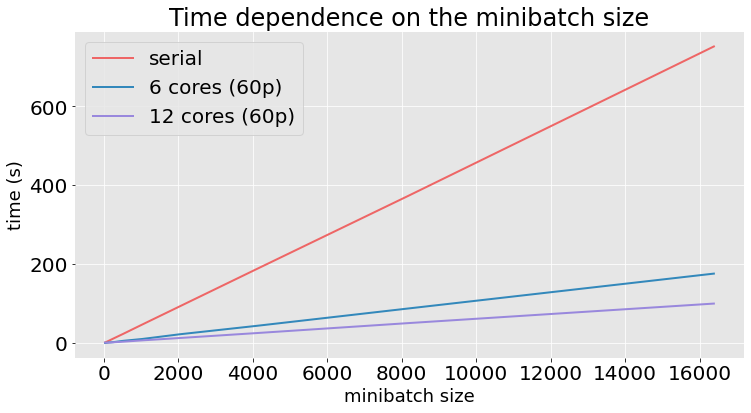

In [19]:
x_12, y_12 = read_exp_data('minibatch_exp_681626_k10_t1_34')
x_6, y_6 = read_exp_data('minibatch_exp_749922_k10_t1_61')
x_serial, y_serial = read_exp_data('minibatch_exp_746199_k10_t1_serial')
plt.plot(x_serial, y_serial, label='serial')
plt.plot(x_6, y_6, label='6 cores (60p)')
plt.plot(x_12, y_12, label='12 cores (60p)')
plt.xlabel('minibatch size', fontsize=18)
plt.ylabel('time (s)', fontsize=18)
plt.title('Time dependence on the minibatch size')
plt.legend()
plt.show()

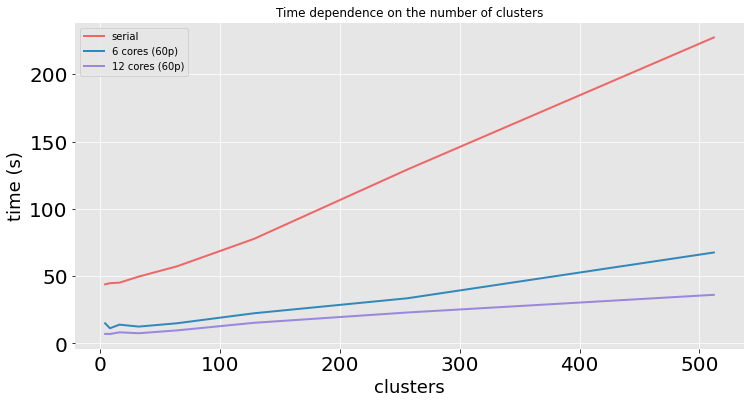

In [48]:
x_12, y_12 = read_exp_data('clusters_exp_902978_k10_t1_121')
x_6, y_6 = read_exp_data('clusters_exp_903800_k10_t1_61')
x_serial, y_serial = read_exp_data('clusters_exp_904018_k10_t1_serial')
plt.plot(x_serial, y_serial, label='serial')
plt.plot(x_6, y_6, label='6 cores (60p)')
plt.plot(x_12, y_12, label='12 cores (60p)')
plt.xlabel('clusters', fontsize=18)
plt.ylabel('time (s)', fontsize=18)
plt.title('Time dependence on the number of clusters')
plt.legend()
plt.show()

### Stop the running Spark context

In [72]:
# 
sc.stop()
spark.stop()

### Start Spark services

To start the Spark execution in the master and worker nodes, issue the following bash command on the master node:

In [ ]:
!$SPARK_HOME/sbin/start-all.sh

### Stop Spark services

To stop the Spark execution in the master and worker nodes, issue the following bash command on the master node:

In [5]:
!$SPARK_HOME/sbin/stop-all.sh

stopping org.apache.spark.deploy.worker.Worker
